# Задание 3. Исследование алгоритмов классификации
Для выполнения данного задания необходимо сначала оценить, насколько набор
данных, выбранный ранее, подходит для решения задачи:
1. В роли целевого класса(метки) выступает атрибут _type_
2. Классы в данном датасете не являются сбалансированными, согласно информации из источника дата сета: _white_ - ***75%***, _red_ - ***25%***.

# Выполнение подзадач
### 1. Необходимо оценить и сравнить результаты классификации, используя следующие алгоритмы классификации: kNN, дерево решений.

#### Шаг 1 -- Предобработка данных

В качестве исследуемого был выбран датасета с сайта [_kaggle_](https://www.kaggle.com/datasets/rajyellow46/wine-quality "Тыкни на меня").

1. Произведем обработку пропусков аналогично прошлой лабораторной работе: если пропусков мало(меньше 5 %), то будем их удалять, в противном случае будем заполнять пропуски, чтобы сохранить объем данных, в численных данных будем заполнять медианой, так как в них имеются выбросы, к которым она устойчива.

In [20]:
import pandas as pd

path_to_data_set = 'C:/Users/fedos/PycharmProjects/JupyterProject/winequalityN.csv'
df = pd.read_csv(path_to_data_set)
cols = df.select_dtypes(include=['float64', 'int64']).columns
df_clean = df.copy()

for col in cols:
    missing = df[col].isnull().sum()
    missing_pct = (missing / len(df)) * 100
    if missing_pct >= 5:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)
    else:
        df_clean.dropna(subset=[col], inplace=True)

2. Закодируем метки классов и удалим атрибуты type и quality из выборки, так как они не являются признаками. Затем проведем стандартизацию данных, применим Robust-масштабирование, так как в данных довольно много выбросов.

In [21]:
from sklearn.preprocessing import RobustScaler

y = df_clean['type'].map({'white': 0, 'red': 1}).values
X = df_clean.drop(columns=['type', 'quality'], axis=1).values
scaler = RobustScaler()
X = scaler.fit_transform(X)

3. Далее разделим датасет на обучающую и тестовую выборки. Так как соотношение меток классов в нашем датасете не сблансировано применим стратификацию при разделении, которая сохранит соотношение классов, представленное в исходном датасете.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Шаг 2 -- Метрический метод kNN

- Подберем оптимальные гиперпараметры модели(метрику расстояния между соседями и k-ближайших соседей) с помощью Grid Search.
- Оценивать качество будем с помощью F-score метрики, так как классы не сбалансированы и использование, например, метрики Accuracy может дать завешенное представление о качестве.
- Обучим модель с заданными гиперапарметрами.

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_hyperparameter_grid = {
    'n_neighbors': range(1, 21),
    'metric': ['euclidean', 'manhattan']
}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_hyperparameter_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)
best_params = grid.best_params_
best_score = grid.best_score_
print(f'Оптимальные гиперпараметры: {best_params}, F-score: {best_score * 100:.2f}%')

knn = KNeighborsClassifier(**best_params)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

Оптимальные гиперпараметры: {'metric': 'manhattan', 'n_neighbors': 8}, F-score: 98.58%


#### Шаг 3 -- Дерево решений

- Подберем оптимальные гиперпараметры модели(максимальная глубина дерева, критерий ветвления, минимальное число семплов в листе дерева) с помощью Grid Search.
- Оценивать качество будем с помощью F-score метрики, так как классы не сбалансированы и использование, например, метрики Accuracy может дать завешенное представление о качестве.
- Обучим модель с заданными гиперапарметрами.

In [23]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)

dt_hyperparameter_grid = {
'max_depth': range(1, 21),
'criterion': ['gini', 'entropy'],
'min_samples_leaf': [1, 5, 10, 20, 50]
}

grid = GridSearchCV(dt, dt_hyperparameter_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)
best_params = grid.best_params_
best_score = grid.best_score_
print(f'Оптимальные гиперпараметры: {best_params}, F-score: {best_score * 100:.2f}%')

dt = DecisionTreeClassifier(**best_params, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

Оптимальные гиперпараметры: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1}, F-score: 96.90%


### 2. Сравните полученные результаты с помощью различных метрик оценки качества: Accuracy, Precision, Recall, F-measure, ROC.

           Model  Accuracy  Precision    Recall  F1-score   ROC AUC
0            kNN  0.997680   0.993750  0.996865  0.995305  0.999942
1  Decision Tree  0.990719   0.990415  0.971787  0.981013  0.988055


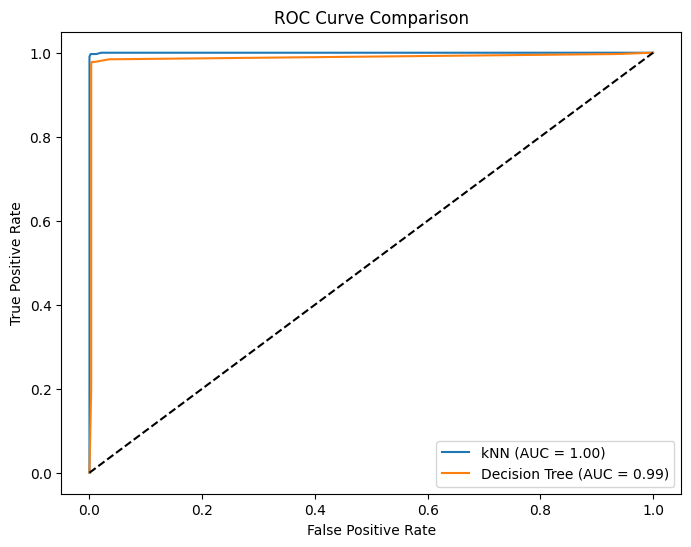

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_prob_knn = knn.predict_proba(X_test)[:, 1]
y_prob_dt = dt.predict_proba(X_test)[:, 1]

metrics = {
    'Model': ['kNN', 'Decision Tree'],
    'Accuracy': [accuracy_score(y_test, y_pred_knn), accuracy_score(y_test, y_pred_dt)],
    'Precision': [precision_score(y_test, y_pred_knn), precision_score(y_test, y_pred_dt)],
    'Recall': [recall_score(y_test, y_pred_knn), recall_score(y_test, y_pred_dt)],
    'F1-score': [f1_score(y_test, y_pred_knn), f1_score(y_test, y_pred_dt)],
    'ROC AUC': [roc_auc_score(y_test, y_prob_knn), roc_auc_score(y_test, y_prob_dt)]
}

df_metrics = pd.DataFrame(metrics)
print(df_metrics)

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f'kNN (AUC = {metrics["ROC AUC"][0]:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {metrics["ROC AUC"][1]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

### 3. Объяснить полученные результаты.

Обе модели показали отличный результат, что видно по площади под ROC-кривой. Это связано с хорошей предобработкой данных и подбором гиперпараметров. Особенно важна предобработка для kNN, который не умеет работать с пропусками без предварительной обработки в отличие от Деревьев Решений, и также kNN чувствителен в данным в разных шкалах -- эта проблема была решена путем стандартизации данных.

Касательно сравнения моделей на различных метриках:
- kNN оказался лучше во всех метриках. Датсет имеет не большую размерность и относительно небольшое количество выбросов и пропусков, которые были обработаны. Вследствие чего было получено качественное представление признаков, что оказывает большое влияние на качество.
- Деревья решений оказались хуже из-за невысокой способности к обобщению и фиксированным границам при принятии решений. Хуже всего деревья показали себя по метрике Recall, это может быть связано с характером данных, где малое количество красных вин пресекается по некоторым признакам с белыми, что дает дереву ошибочное представление при построении.